<a href="https://colab.research.google.com/github/vicben2/hgraph2graph/blob/main/Parta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!git clone https://github.com/wengong-jin/hgraph2graph

Cloning into 'hgraph2graph'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 364 (delta 113), reused 92 (delta 92), pack-reused 212 (from 1)
Receiving objects: 100% (364/364), 153.12 MiB | 18.69 MiB/s, done.
Resolving deltas: 100% (218/218), done.
Updating files: 100% (89/89), done.


In [10]:
%cd hgraph2graph

/content/hgraph2graph


In [11]:
!pip install rdkit networkx tqdm
import torch
from torch.utils.data import DataLoader
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit import DataStructs
import sys
import os
from hgraph import HierVAE, MolGraph, common_atom_vocab, Vocab, PairVocab
from hgraph import MoleculeDataset

In [12]:
class Args:
  def __init__(self):
    self.vocab = None
    self.atom_vocab = common_atom_vocab
    self.rnn_type = 'LSTM'
    self.hidden_size = 250
    self.embed_size = 250
    self.batch_size = 20
    self.latent_size = 32
    self.depthT = 15
    self.depthG = 15
    self.diterT = 1
    self.diterG = 3
    self.dropout = 0.0

args = Args()

seed = 7

torch.manual_seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#vocab
vocab_path = 'data/chembl/vocab.txt'
vocab = [x.strip("\r\n ").split() for x in open(vocab_path)]
args.vocab = PairVocab(vocab, cuda=(device.type == 'cuda')) # FIX: Explicitly pass cuda argument

model_path = 'ckpt/chembl-pretrained/model.ckpt'
model = HierVAE(args).to(device)

checkpoint = torch.load(model_path, map_location=device)
if isinstance(checkpoint, tuple):
    model.load_state_dict(checkpoint[0])
else:
    model.load_state_dict(checkpoint)

model.eval()

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


HierVAE(
  (encoder): HierMPNEncoder(
    (E_c): Sequential(
      (0): Embedding(1578, 250)
      (1): Dropout(p=0.0, inplace=False)
    )
    (E_i): Sequential(
      (0): Embedding(5623, 250)
      (1): Dropout(p=0.0, inplace=False)
    )
    (W_c): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (W_i): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (W_root): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): Tanh()
    )
    (tree_encoder): MPNEncoder(
      (W_o): Sequential(
        (0): Linear(in_features=500, out_features=250, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
      )
      (rnn): LSTM(
        (W_i): Sequential(
          (0): Linear(in_features=520, out_features=250, bias=True)
          (1): Sigmoid()
       

In [13]:
input_smiles = [
    "CC(=O)Oc1ccccc1C(=O)O", #aspirin
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", #caffeine
    "CC(=O)Nc1ccc(O)cc1", #paracetamol
    "CCO", #ethanol
    "CC(C)Cc1ccc(C(C)C(=O)O)cc1", #ibuprofen
    "C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C", #cholesterol
    "C1=CC2=C(C=C1O)C(=CN2)CCN", #serotonin
    "CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O", #morphine
    "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O", #glucose
    "CN1CCC[C@H]1C2=CN=CC=C2", #nicotine
    "C1=CC=NC=C1", #pyridine
    "C1COCCN1", #morpholine
    "C12C3C4C1C5C2C3C45", #cubane
    "C1=CC=C2C=CC=CC2=C1", #napthalene
    "C[C@@H](C(=O)O)N", #l-alanine
    "C(Cl)(Cl)Cl", #chloroform
    "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C", #penicillin
    "C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O)N", #atp
    "CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O",
    "B1NBNBN1",
    "C=C=C",
    "C1=CC=C(C=C1)[N+]#N.[Cl-]",
    "[2H]O[2H]",
    "CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+]",
    "c12c3c4c5c1c6c7c8c2c9c1c3c2c3c4c4c5c5c6c6c7c7c8c9c8c9c1c2c1c2c3c4c3c4c5c6c5c6c7c8c7c9c1c1c2c3c4c5c6c71",
    "C1CN2CC3=C(C24C1C5C6C4C7C5CC(C6=O)OC7)NC8=CC=CC=C38",
    "C1C2CC3CC1CC(C2)C3",
    "[CH-]=C/C=C\\C=C/C=[Fe+]",
    "CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)C(C(C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)O",
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)C",
    "CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]"
]

valid_smiles = []
for s in input_smiles:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        can_smi = Chem.MolToSmiles(mol)
        valid_smiles.append(can_smi)
    else:
        print(f"Invalid: {s}")

print(len(valid_smiles))

31


In [14]:
def reconstruct_molecules(model, smiles_list, vocab, atom_vocab, batch_size=20):
    results = []

    compatible_smiles = []
    for smi in smiles_list:
        try:
            hmol = MolGraph(smi)
            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                ok &= attr['label'] in vocab.vmap
                for i, s in attr['inter_label']:
                    ok &= (smiles_node, s) in vocab.vmap
            if ok:
                compatible_smiles.append(smi)
            else:
                results.append((smi, None, "Not in vocabulary"))
        except Exception as e:
            results.append((smi, None, f"Error:  {str(e)}"))

    if len(compatible_smiles) == 0:
        print("No compatible molecules found!")
        return results

    dataset = MoleculeDataset(compatible_smiles, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x: x[0])

    #reconstruct
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Reconstructing"):
            start_idx = batch_size * batch_idx
            end_idx = min(batch_size * (batch_idx + 1), len(compatible_smiles))
            orig_smiles_batch = compatible_smiles[start_idx: end_idx]

            try:
                dec_smiles = model.reconstruct(batch)
                for orig, dec in zip(orig_smiles_batch, dec_smiles):
                    results.append((orig, dec, "Success"))
            except Exception as e:
                for orig in orig_smiles_batch:
                    results.append((orig, None, f"Decode error: {str(e)}"))

            batch_idx += 1

    return results

In [15]:
def calculate_tanimoto(smiles1, smiles2, radius=2, nBits=2048):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return None

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius, nBits=nBits)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius, nBits=nBits)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

def get_mol_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        'num_atoms': mol. GetNumAtoms(),
        'num_bonds': mol.GetNumBonds(),
        'num_rings':  Chem.GetSSSR(mol).__len__(),
    }

def calculate_error_diagnostics(smiles_in, smiles_out):
    mol_in = Chem.MolFromSmiles(smiles_in)
    mol_out = Chem.MolFromSmiles(smiles_out)

    if mol_in is None or mol_out is None:
        return None

    props_in = get_mol_properties(smiles_in)
    props_out = get_mol_properties(smiles_out)

    return {
        'delta_atoms': props_out['num_atoms'] - props_in['num_atoms'],
        'delta_bonds': props_out['num_bonds'] - props_in['num_bonds'],
        'delta_rings': props_out['num_rings'] - props_in['num_rings'],
    }

def is_exact_match(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return False

    can1 = Chem.MolToSmiles(mol1)
    can2 = Chem. MolToSmiles(mol2)

    return can1 == can2

def is_valid_molecule(smiles):
    if smiles is None or smiles == "":
        return False
    mol = Chem. MolFromSmiles(smiles)
    return mol is not None

In [ ]:
import requests
import time

def reconstruct_molecules(model, smiles_list, vocab, atom_vocab, batch_size=20):
    results = []

    compatible_smiles = []
    for smi in smiles_list:
        try:
            hmol = MolGraph(smi)
            ok = True
            # Check mol_tree nodes against vocab
            for node_id, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                # Check fragment label
                if attr['label'] not in vocab.vmap:
                    ok = False
                    break
                # Check inter_label
                for i, s in attr['inter_label']:
                    if (smiles_node, s) not in vocab.vmap:
                        ok = False
                        break
                if not ok:
                    break

            # Add check for mol_graph nodes against atom_vocab
            if ok: # Only proceed if mol_tree check passed
                for node_id in hmol.mol_graph.nodes():
                    atom_features = hmol.mol_graph.nodes[node_id]['label'] # Assuming 'label' holds (symbol, charge)
                    if atom_features not in atom_vocab.vmap:
                        ok = False
                        break # No need to check further for this molecule

            if ok:
                compatible_smiles.append(smi)
            else:
                results.append((smi, None, "Not in vocabulary (or atom_vocab)")) # Refined error message
        except Exception as e:
            results.append((smi, None, f"Error initializing MolGraph for {smi}: {str(e)}"))

    if len(compatible_smiles) == 0:
        print("No compatible molecules found!")
        return results

    dataset = MoleculeDataset(compatible_smiles, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x: x[0])

    #reconstruct
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Reconstructing"): # tqdm was causing some issues with batch_size
            start_idx = batch_size * batch_idx
            end_idx = min(batch_size * (batch_idx + 1), len(compatible_smiles))
            orig_smiles_batch = compatible_smiles[start_idx: end_idx]

            try:
                dec_smiles = model.reconstruct(batch)
                for orig, dec in zip(orig_smiles_batch, dec_smiles):
                    results.append((orig, dec, "Success"))
            except Exception as e:
                for orig in orig_smiles_batch:
                    results.append((orig, None, f"Decode error for {orig}: {str(e)}"))

            batch_idx += 1

    return results


#results init
reconstruction_results = reconstruct_molecules(
    model,
    valid_smiles,
    args.vocab,
    args.atom_vocab,
    batch_size=args.batch_size
)


#experiment
def check_patent_status(smiles):
    """Queries PubChem PUG REST API for patent annotations."""
    if not smiles:
        return False, 0
    try:
        url_cid = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/cids/JSON"
        res_cid = requests.post(url_cid, data={"smiles": smiles}, timeout=10)
        if res_cid.status_code != 200:
            return False, 0

        cid = res_cid.json().get('IdentifierList', {}).get('CID', [None])[0]
        if not cid:
            return False, 0

        url_xref = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/xrefs/PatentID/JSON"
        res_xref = requests.get(url_xref, timeout=10)
        if res_xref.status_code == 200:
            patents = res_xref.json().get('InformationList', {}).get('Information', [{}])[0].get('PatentID', [])
            return len(patents) > 0, len(patents)
        return False, 0
    except:
        return False, 0

results_data = []

for idx, (smiles_in, smiles_out, status) in enumerate(reconstruction_results):
    # Online patent lookup
    is_pat_in, count_in = check_patent_status(smiles_in)
    is_pat_out, count_out = (False, 0)

    valid_out = 1 if (smiles_out and Chem.MolFromSmiles(smiles_out)) else 0
    if valid_out:
        is_pat_out, count_out = check_patent_status(smiles_out)

    row = {
        'id': idx,
        'smiles_in': smiles_in,
        'smiles_out': smiles_out if smiles_out else "",
        'valid_out': valid_out,
        'exact_match': 1 if (smiles_out and is_exact_match(smiles_in, smiles_out)) else 0,
        'tanimoto': calculate_tanimoto(smiles_in, smiles_out) if valid_out else None,
        'status': status,
        'patented_in': 1 if is_pat_in else 0,
        'patent_count_in': count_in,
        'patented_out': 1 if is_pat_out else 0,
        'patent_count_out': count_out
    }

    # Add error diagnostics if valid
    if valid_out:
        diag = calculate_error_diagnostics(smiles_in, smiles_out)
        if diag:
            row.update({f'delta_{k}': v for k, v in diag.items()})

    results_data.append(row)
    time.sleep(0.2) #PubChem API limits (5 requests/sec)

#csv
df = pd.DataFrame(results_data)
df.to_csv('results.csv', index=False)
print("Results saved to 'reconstruction_results_with_patents.csv'")

After pruning 21 -> 21


Reconstructing: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Results saved to 'reconstruction_results_with_patents.csv'


Summary:

Summary Statistics:
               Metric  Value
         Total Tested     31
Valid Reconstructions     21
        Exact Matches      5
     Patented (Input)     11
    Patented (Output)      9
         Avg Tanimoto 0.4888

Error diagnostics:
 Diagnostic  Avg  Lowest  Highest
Delta Atoms 3.95    -6.0     19.0
Delta Bonds 4.52    -9.0     23.0
Delta Rings 0.52    -3.0      4.0


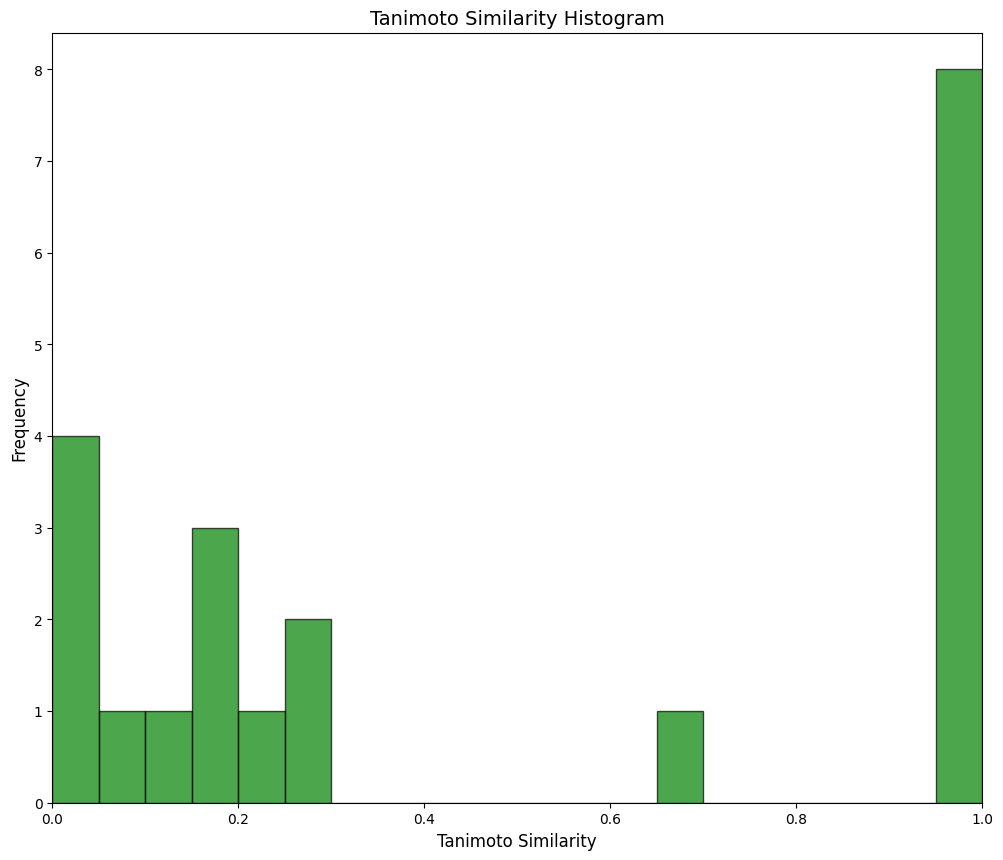

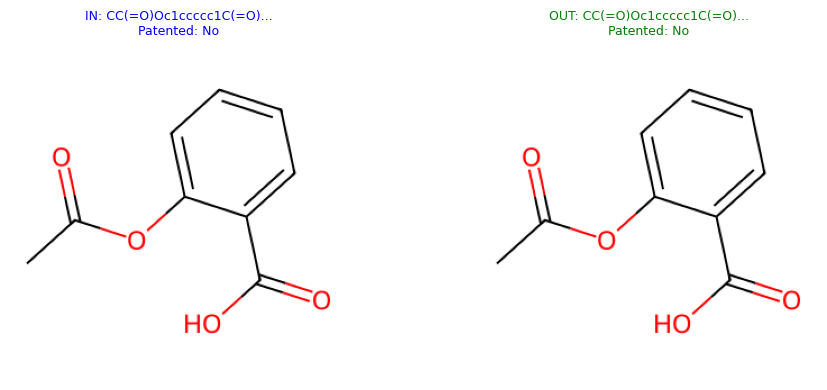

The model reconstructed CC(=O)Oc1ccccc1C(=O)O exactly.


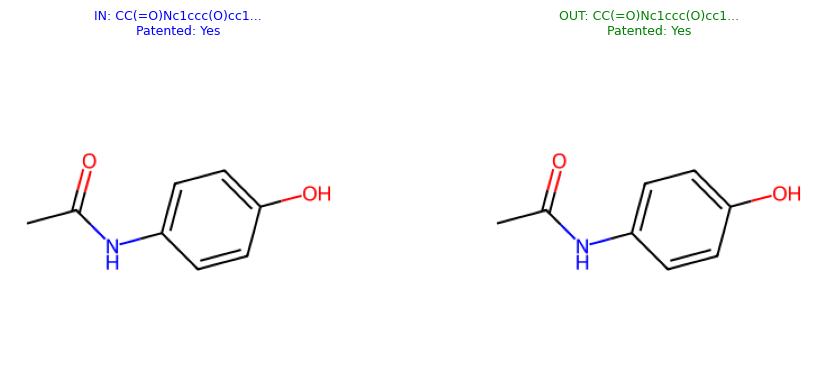

The model reconstructed CC(=O)Nc1ccc(O)cc1 exactly.


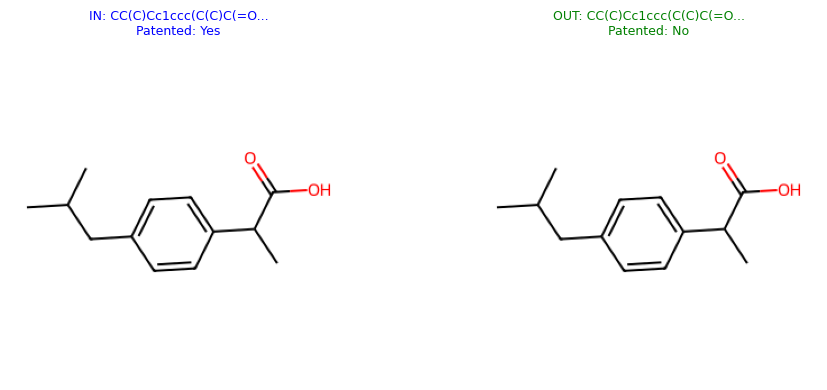

The model reconstructed CC(C)Cc1ccc(C(C)C(=O)O)cc1 exactly.


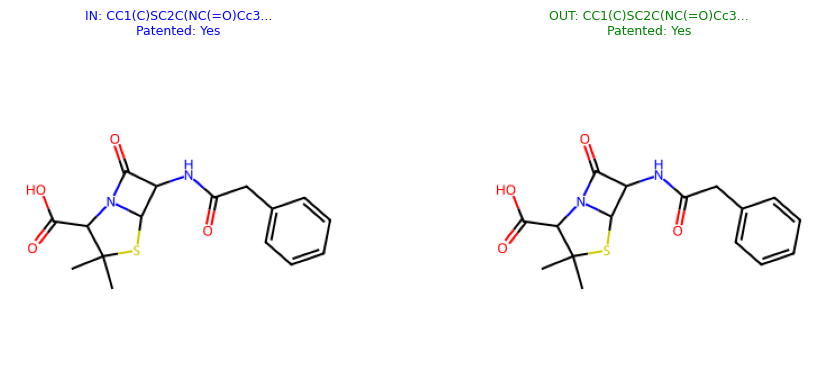

The model reconstructed CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O exactly.


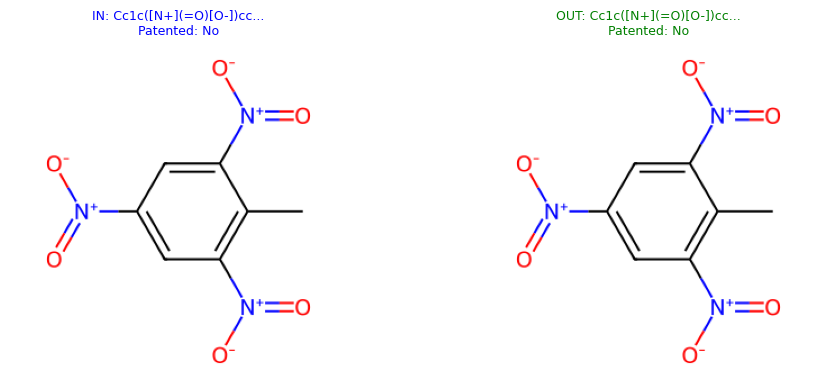

The model reconstructed Cc1c([N+](=O)[O-])cc([N+](=O)[O-])cc1[N+](=O)[O-] exactly.


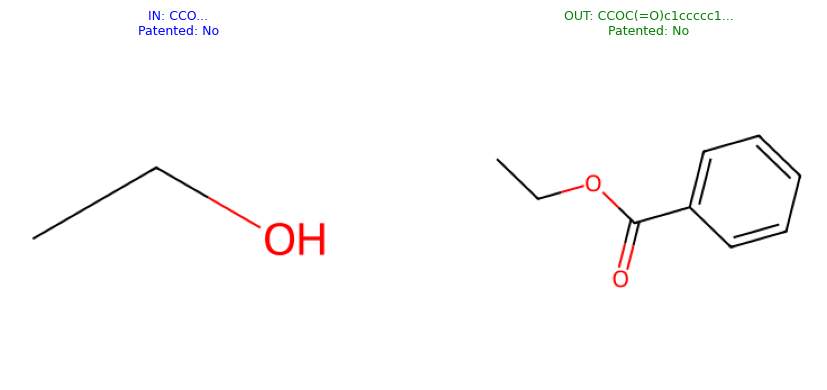

Significant reconstruction differences (Tanimoto: 0.17).


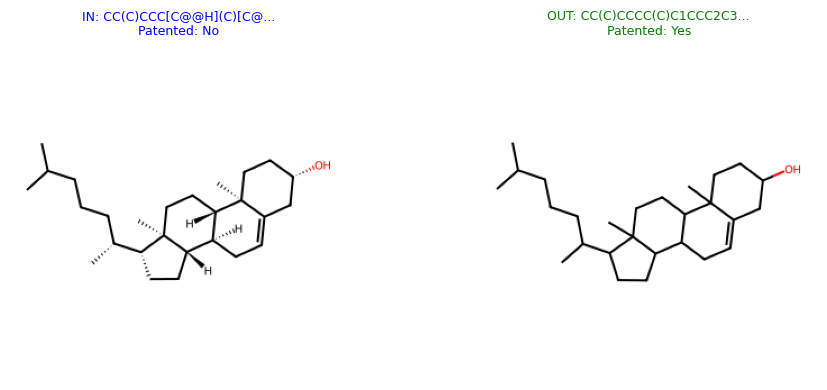

Almost similar with minor differences (Tanimoto: 1.00).


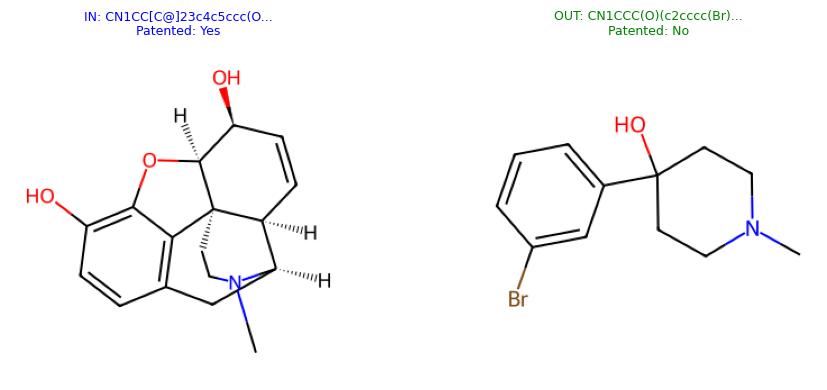

Significant reconstruction differences (Tanimoto: 0.21).


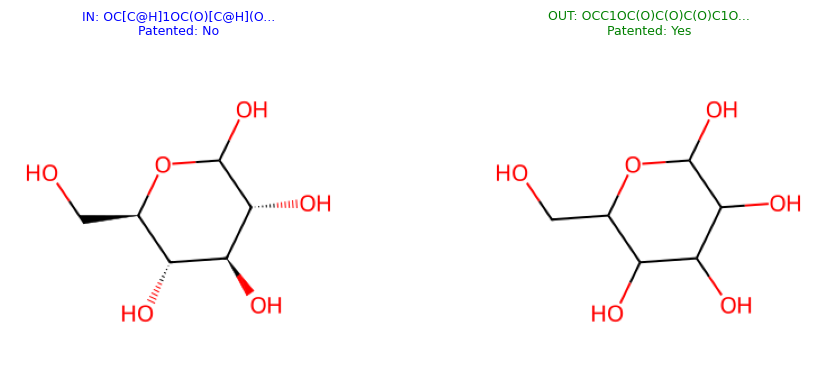

Almost similar with minor differences (Tanimoto: 1.00).


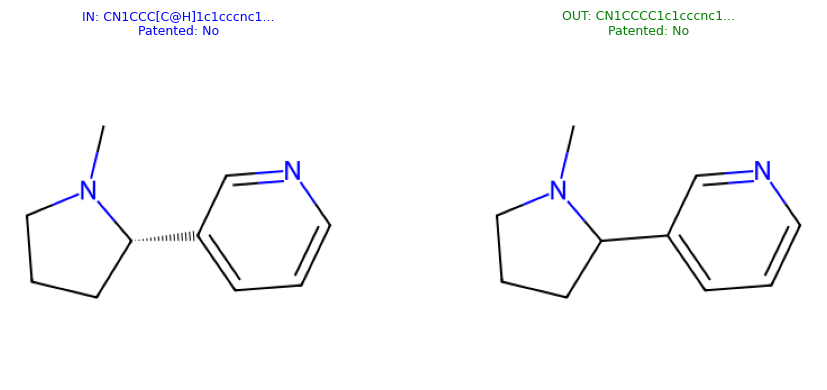

Almost similar with minor differences (Tanimoto: 1.00).


In [ ]:
#summary
total_molecules = len(df)
valid_outputs = df['valid_out']. sum()
exact_matches = df['exact_match'].sum()
valid_df = df[df['valid_out'] == 1]

print("Summary:")

summary_table = pd.DataFrame({
    'Metric': [
        'Total Tested', 'Valid Reconstructions', 'Exact Matches',
        'Patented (Input)', 'Patented (Output)', 'Avg Tanimoto'
    ],
    'Value': [
        len(df), df['valid_out'].sum(), df['exact_match'].sum(),
        df['patented_in'].sum(), df['patented_out'].sum(),
        f"{df['tanimoto'].mean():.4f}" if df['valid_out'].any() else "N/A"
    ]
})
print("\nSummary Statistics:")
print(summary_table.to_string(index=False))
print()

if len(valid_df) > 0:
    print("Error diagnostics:")

    error_summary = pd.DataFrame({
        'Diagnostic': ['Delta Atoms', 'Delta Bonds', 'Delta Rings'],
        'Avg': [
            f"{valid_df['delta_delta_atoms'].mean():.2f}",
            f"{valid_df['delta_delta_bonds'].mean():.2f}",
            f"{valid_df['delta_delta_rings'].mean():.2f}"
        ],
        'Lowest': [
            valid_df['delta_delta_atoms'].min(),
            valid_df['delta_delta_bonds'].min(),
            valid_df['delta_delta_rings'].min()
        ],
        'Highest': [
            valid_df['delta_delta_atoms'].max(),
            valid_df['delta_delta_bonds'].max(),
            valid_df['delta_delta_rings'].max()
        ]
    })

    print(error_summary.to_string(index=False))

fig, ax1 = plt.subplots(figsize=(12, 10))

if len(valid_df) > 0:
    ax1.hist(valid_df['tanimoto'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='green')

ax1.set_xlabel('Tanimoto Similarity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Tanimoto Similarity Histogram', fontsize=14)
ax1.set_xlim(0, 1)

plt.show()
print()

def draw_molecules(smiles_in, smiles_out, idx, tanimoto, exact_match):
    m_in = Chem.MolFromSmiles(smiles_in)
    m_out = Chem.MolFromSmiles(smiles_out) if smiles_out else None

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Label Input
    label_in = f"IN: {smiles_in[:20]}...\nPatented: {'Yes' if df.loc[df['id'] == idx, 'patented_in'].iloc[0] else 'No'}"
    if m_in:
        axes[0].imshow(Draw.MolToImage(m_in, size=(300, 300)))
        axes[0].set_title(label_in, fontsize=9, color='blue')
    axes[0].axis('off')

    # Label Output
    label_out = f"OUT: {smiles_out[:20]}...\nPatented: {'Yes' if df.loc[df['id'] == idx, 'patented_out'].iloc[0] else 'No'}"
    if m_out:
        axes[1].imshow(Draw.MolToImage(m_out, size=(300, 300)))
        axes[1].set_title(label_out, fontsize=9, color='green')
    axes[1].axis('off')

    plt.tight_layout()
    return fig


examples = []
num_examples_to_show = 10

# Get exact matches
exact_match_examples = df[df['exact_match'] == 1].copy()
# Get non-exact but valid reconstructions
non_exact_valid_examples = df[(df['exact_match'] == 0) & (df['valid_out'] == 1)].copy()
# Get invalid reconstructions
invalid_examples = df[df['valid_out'] == 0].copy()

# Prioritize exact matches, then non-exact valid, then invalid
examples_df = pd.concat([
    exact_match_examples.head(num_examples_to_show // 2),
    non_exact_valid_examples.head(num_examples_to_show - (num_examples_to_show // 2)),
    invalid_examples
]).head(num_examples_to_show).reset_index(drop=True)


for i, row in examples_df.iterrows():
    smiles_in = row['smiles_in']
    smiles_out = row['smiles_out']
    exact = row['exact_match']
    tanimoto = row['tanimoto']

    fig = draw_molecules(smiles_in, smiles_out, row['id'], tanimoto, exact)
    plt.show()

    if exact:
        interp = f"The model reconstructed {smiles_in} exactly."
    elif row['valid_out'] == 0:
        interp = f"The model did not reconstruct {smiles_in} correctly (Status: {row['status']})."
    else:
        delta_atoms = row.get('delta_delta_atoms', 0)
        delta_bonds = row.get('delta_delta_bonds', 0)
        if tanimoto and tanimoto > 0.9:
            interp = f"Almost similar with minor differences (Tanimoto: {tanimoto:.2f})."
        elif tanimoto and tanimoto > 0.7:
            interp = f"Good reconstruction with noticeable differences (Tanimoto: {tanimoto:.2f})."
        else:
            interp = f"Significant reconstruction differences (Tanimoto: {tanimoto:.2f})."

    print(interp)


Saved tanimoto_dist.png
Saved qualitative_grid.png


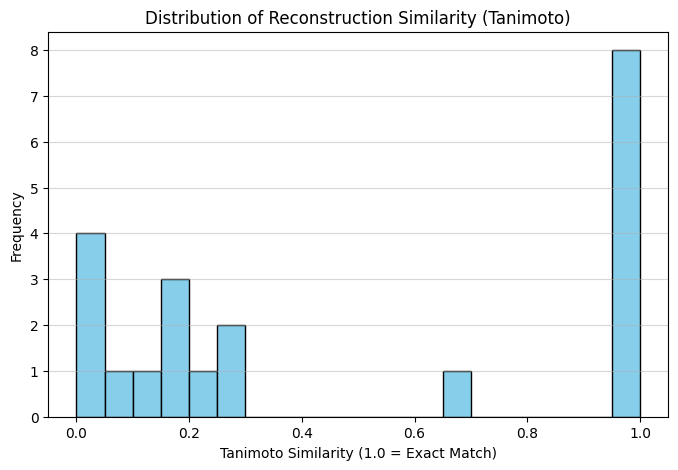

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# Load Data
df = pd.read_csv('results.csv')


plt.figure(figsize=(8, 5))
plt.hist(df['tanimoto'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Reconstruction Similarity (Tanimoto)')
plt.xlabel('Tanimoto Similarity (1.0 = Exact Match)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.savefig('tanimoto_dist.png', dpi=300)
print("Saved tanimoto_dist.png")


# We pick a mix of good matches and failures
subset = df.sample(8, random_state=42)
mols = []
legends = []

for idx, row in subset.iterrows():
    if pd.isna(row['smiles_out']): continue
    m = Chem.MolFromSmiles(row['smiles_in'])
    rec = Chem.MolFromSmiles(row['smiles_out'])
    if m and rec:
        mols.append(m)
        mols.append(rec)
        legends.append(f"In #{row['id']}")
        legends.append(f"Out (Tan: {row['tanimoto']:.2f})")

# Force PIL return with returnPNG=False to fix the "no attribute save" error
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends, returnPNG=False)
img.save('qualitative_grid.png')
print("Saved qualitative_grid.png")